In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import urllib.request
import gzip
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

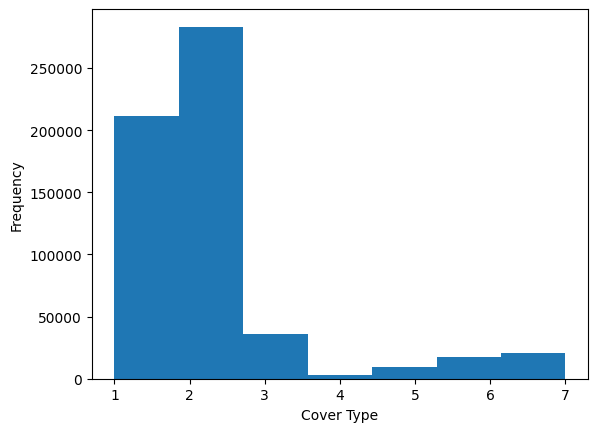

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

# Download the data
urllib.request.urlretrieve(url, "covtype.data.gz")

# Extract the data
with gzip.open("covtype.data.gz", "rb") as f:
    data = f.read().decode("utf-8")


# Parse the data into a list of lists
rows = data.strip().split("\n")
data_list = [list(map(int, row.split(","))) for row in rows]

# Get the target variable from the data
target = [row[-1] for row in data_list]

# Create a histogram of the target variable
plt.hist(target, bins=7)
plt.xlabel("Cover Type")
plt.ylabel("Frequency")
plt.show()

In [4]:
# Download the dataset from UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
filename = "covtype.data.gz"
urllib.request.urlretrieve(url, filename)

# Define the column names for the dataset
feature_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
                 'Horizontal_Distance_To_Fire_Points'] + ['Wilderness_Area_{}'.format(i) for i in range(4)] + ['Soil_Type_{}'.format(i) for i in range(40)] + ['Cover_Type']

# Load the dataset using Pandas
df = pd.read_csv(filename, header=None, names=feature_names)

# Split the dataset into features and labels
X = df.drop('Cover_Type', axis=1).values
y = df['Cover_Type'].values - 1  # subtract 1 to make class labels start from 0

# Perform feature scaling using the StandardScaler class from sklearn.preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split the dataset into features and labels
X = df.drop('Cover_Type', axis=1).values
y = df['Cover_Type'].values - 1  # subtract 1 to make class labels start from 0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform feature scaling using the StandardScaler class from sklearn.preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the training and testing data into TensorFlow tensors
X_train_scaled = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
X_test_scaled = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Create TensorFlow datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))

# Define a function to preprocess the features in a dataset
def preprocess_features(features):
    # Normalize the features
    normalized_features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return normalized_features

# Preprocess the training and testing features
X_train = preprocess_features(X_train)
X_test = preprocess_features(X_test)

# Convert the preprocessed training and testing features back into TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Create new TensorFlow datasets using the preprocessed features and original labels
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [5]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_shape=(54,), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96)

# Compile the model with the learning rate schedule and using the SparseCategoricalCrossentropy loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


# Train the model with the modified architecture and parameters
history = model.fit(train_dataset.batch(32), epochs=10, validation_data=test_dataset.batch(32))

# Evaluate the model
model.evaluate(test_dataset.batch(32))


Epoch 1/10
14526/14526 [==============================] - 1534s 106ms/step - loss: 0.7676 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.5388 - val_sparse_categorical_accuracy: 0.7750
Epoch 2/10
14526/14526 [==============================] - 1504s 104ms/step - loss: 0.5700 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.4779 - val_sparse_categorical_accuracy: 0.7988
Epoch 3/10
14526/14526 [==============================] - 1466s 101ms/step - loss: 0.5195 - sparse_categorical_accuracy: 0.7769 - val_loss: 0.4384 - val_sparse_categorical_accuracy: 0.8188
Epoch 4/10
14526/14526 [==============================] - 1517s 104ms/step - loss: 0.4881 - sparse_categorical_accuracy: 0.7915 - val_loss: 0.4080 - val_sparse_categorical_accuracy: 0.8337
Epoch 5/10
14526/14526 [==============================] - 1487s 102ms/step - loss: 0.4641 - sparse_categorical_accuracy: 0.8026 - val_loss: 0.3866 - val_sparse_categorical_accuracy: 0.8434
Epoch 6/10
14526/14526 [==============================]

[0.3233625888824463, 0.8709843754768372]

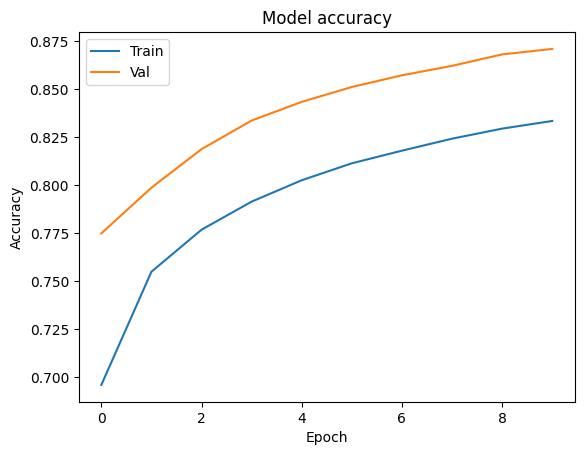

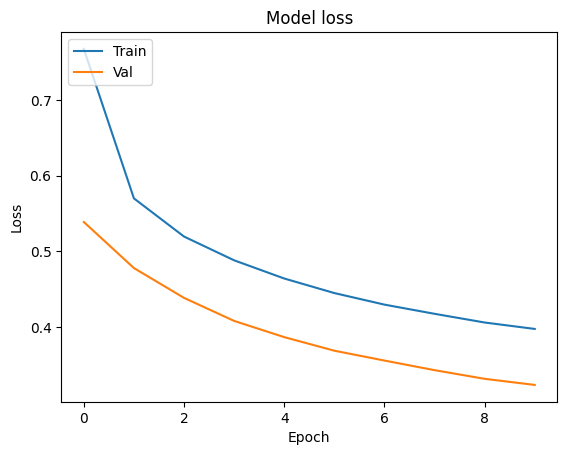

In [6]:
# Plot the training and validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [7]:
#show more information about the history of the model
print(history.history)

{'loss': [0.767620325088501, 0.569987952709198, 0.5195311903953552, 0.48812001943588257, 0.46407052874565125, 0.44482696056365967, 0.4295431971549988, 0.417385458946228, 0.4058913588523865, 0.39738863706588745], 'sparse_categorical_accuracy': [0.696096658706665, 0.7550133466720581, 0.7768846750259399, 0.7914950251579285, 0.8026286363601685, 0.811449408531189, 0.8180198669433594, 0.8242654800415039, 0.8295019865036011, 0.8334821462631226], 'val_loss': [0.5387712121009827, 0.47788336873054504, 0.43844783306121826, 0.40798816084861755, 0.38656380772590637, 0.3686085045337677, 0.35559532046318054, 0.3428751528263092, 0.3314304053783417, 0.3233625888824463], 'val_sparse_categorical_accuracy': [0.7749541997909546, 0.7987573742866516, 0.8188170790672302, 0.8337134122848511, 0.8434291481971741, 0.8511742353439331, 0.8572497963905334, 0.8621636033058167, 0.8681273460388184, 0.8709843754768372]}


In [8]:
# Save the entire model to a single file
model.save('my_model.h5')

In [9]:
# Save only the weights of the model to a file
model.save_weights('my_model_weights.h5')